In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import dit
import libtsm

import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
#
# Global settings
#

fs = 48000.
voices = ['S', 'A', 'T', 'B']

total_duration = 8. # seconds

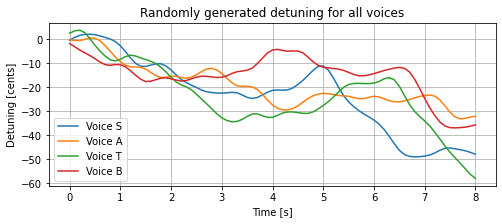

In [4]:
#
# Generate random "detuning curves" for all voices
#

np.random.seed(4242)
dt = 0.1 # step size in seconds
win_size = 8 # smoothing window for random detuning

detune = {}

num_frames = int(total_duration/dt)+1

plt.figure(figsize=(8,3))

t = np.linspace(0, total_duration, num_frames)

for voice in voices:
    y = np.cumsum(np.random.rand(num_frames) * 20 - 12) # slightly favoring downwards
    detune[voice] = np.convolve(
        np.pad(y, (int(win_size/2)-1, int(win_size/2)), 'edge'),
        np.hamming(win_size)/win_size,
        mode='valid'
    )

    plt.plot(t, detune[voice], label="Voice %s" % voice)

plt.title("Randomly generated detuning for all voices")
plt.xlabel("Time [s]")
plt.ylabel("Detuning [cents]")
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# 
# Synthesize audio with the detuning curves above
#

def synth_voice_detuned(tones, duration, dt, fs, curve, **kwargs):
    result = np.zeros((int(duration*fs)))
    i = 0
    t = 0.
    j = 0
    for tone in tones:
        l = int(tone[0] * fs)
        win = np.ones((l))
        win[:100] = np.sin(np.linspace(0, np.pi/2, 100))
        win[-100:] = np.cos(np.linspace(0, np.pi/2, 100))
        sig = np.zeros((l))
        carry = []
        i1 = 0
        for t1 in np.arange(t, t+tone[0], dt):
            l1 = int(dt * fs)
            sig[i1:i1+l1], carry = dit.utils.synth(
                dit.utils.s2f(tone[1]) * np.power(2, curve[j]/1200),
                dt, fs=fs, init_phase=carry, **kwargs
            )
            i1 += l1
            j += 1
        result[i:i+l] += win * sig
        i += l
        t += tone[0]
    return result

d = total_duration/4
sheet_music = {
    'S': [(d, "A4"), (d, "A4"), (d, "A4"), (d, "G4")],
    'A': [(d, "F4"), (d, "E4"), (d, "Eb4"), (d, "D4")],
    'T': [(d, "C4"), (d, "C4"), (d, "C4"), (d, "Bb3")],
    'B': [(d, "F3"), (d, "A3"), (d, "F#3"), (d, "G3")],
}

x = {}
x_mix = np.zeros((int(total_duration*fs)))
for voice in voices:
    x[voice] = 0.5 * synth_voice_detuned(sheet_music[voice], total_duration, dt, fs, detune[voice])
    x_mix += x[voice]

ipd.display(ipd.Audio(x_mix, rate=fs))

In [6]:
#
# Calculate peaks for each voice
#

# settings for analysis
frame_length = int(dt * fs) # in samples
fft_size = 4096 # in samples
adapt_rate = 350 # 350 # # in samples

# settings for peak detection
filter_len = 10 # in samples, window size for harmonic-percussive separation
freq_lim = 8000 # in Hz, highest possible frequency of a peak
peak_threshold = 0 # in dB, minimum peak level
peak_prominence = 10 # in dB, minimum difference between peak and its surrounding
peak_distance = 1 # in bins, minimum distance between peaks
max_peaks = 16


P = []

for voice in voices:
    print("Finding peaks for %s..." % voice)
    time, peaks, _ = dit.utils.find_peaks(x[voice], fs, fft_size, frame_length, max_peaks, filter_len, freq_lim,
                                         height=peak_threshold, distance=peak_distance, prominence=peak_prominence)
    P.append(peaks)
    
P = np.array(P)
print("Done!")

Finding peaks for S...
Finding peaks for A...
Finding peaks for T...
Finding peaks for B...
Done!


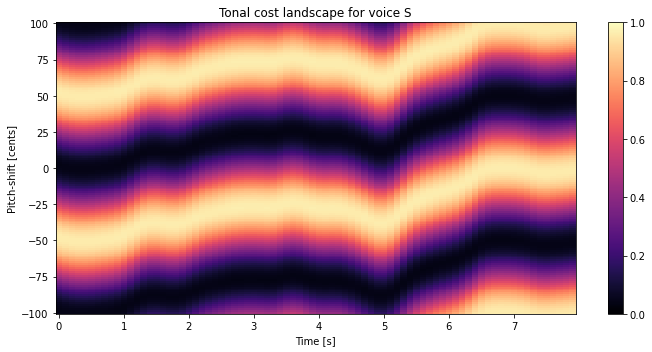

In [16]:
#
# Calculate a "tonal cost landscape", showing which pitch-shifts result in a lower tonal cost
#

L = P.shape[1] # number of time frames
M = P.shape[2] # number of frequencies per voice
N = 150 # resolution of the cost calculation
v = voices.index('S') # voice of interest

cents = np.linspace(-100, 100, N)
factors = np.power(2, cents/1200)

P_lead = P[v]
# accumulate all other voices in a single set
backing_voices = []
for i in range(len(voices)):
    if i == v: continue
    backing_voices.append(P[i])
P_backing = np.concatenate(backing_voices, axis=1)

result = np.zeros((L, N))

for n in range(N):
    P_test = P_lead.copy()
    P_test[:,:,0] *= factors[n]

    result[:,n] = dit.cost.tonal_for_frames(P_test, P_backing, fit_grid=False, f_ref=440., gradient=False)

plt.figure(figsize=(10,5), tight_layout=True)
plt.pcolormesh(t[:-1], cents, result.T, vmin=0, vmax=1, cmap="magma", shading="auto")

plt.title("Tonal cost landscape for voice %s" % voices[v])
plt.xlabel("Time [s]")
plt.ylabel("Pitch-shift [cents]")
plt.colorbar()
plt.show()

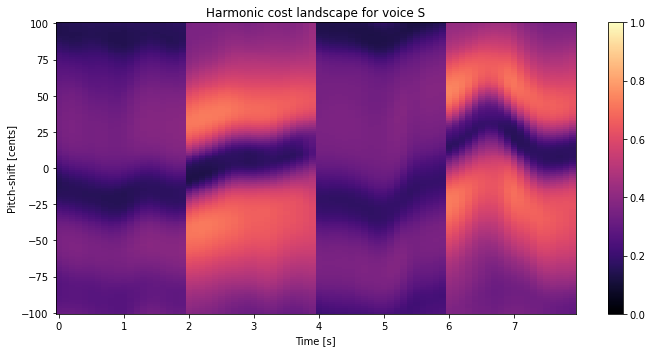

In [17]:
#
# Calculate a "harmonic cost landscape", showing which pitch-shifts result in a lower harmonic cost
# (this may be a bit slow)
#

L = P.shape[1] # number of time frames
M = P.shape[2] # number of frequencies per voice
N = 150 # resolution of the cost calculation
v = voices.index('S') # voice of interest

cents = np.linspace(-100, 100, N)
factors = np.power(2, cents/1200)

P_lead = P[v]
# accumulate all other voices in a single set
backing_voices = []
for i in range(len(voices)):
    if i == v: continue
    backing_voices.append(P[i])
P_backing = np.concatenate(backing_voices, axis=1)

result = np.zeros((L, N))
for n in range(N):
    P_test = P_lead.copy()
    P_test[:,:,0] *= factors[n]

    result[:,n] = dit.cost.harmonic_for_frames(P_test, P_backing, fixed_wc=0.03, gradient=False)

plt.figure(figsize=(10,5), tight_layout=True)
plt.pcolormesh(t[:-1], cents, result.T, vmin=0, vmax=1, cmap="magma", shading="auto")

plt.title("Harmonic cost landscape for voice %s" % voices[v])
plt.xlabel("Time [s]")
plt.ylabel("Pitch-shift [cents]")
plt.colorbar()
plt.show()

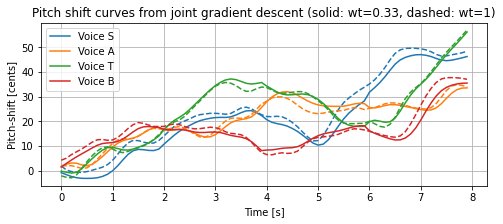

In [32]:
#
# Run joint gradient descent on all voices to find the best pitch-shift curve for each 
#

shifts_a = dit.analysis.calc_shifts_multivoice(P, wt=0.33, wh=0.67, mu=650)
shifts_b = dit.analysis.calc_shifts_multivoice(P, wt=1., wh=0., mu=650)

plt.figure(figsize=(8,3))

t = np.arange(0, shifts_a.shape[1]) * dt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(shifts_a)):
    plt.plot(t, shifts_a[i], color=colors[i], label="Voice %s" % voices[i])
    plt.plot(t, shifts_b[i], color=colors[i], linestyle="--")

plt.title("Pitch shift curves from joint gradient descent (solid: wt=0.33, dashed: wt=1)")
plt.xlabel("Time [s]")
plt.ylabel("Pitch-shift [cents]")
plt.grid(True)
plt.legend()
plt.show()

In [33]:
#
# Apply pitch-shift curves from above using adaptive pitch-shifting from libtsm 
#
y = {}
y_mix = np.zeros((int(total_duration*fs)))
for voice in voices:
    y[voice] = libtsm.pitch_shift(x[voice], shifts_b[voices.index(voice)], t)[:,0]
    y_mix += y[voice]

print("Original:")
ipd.display(ipd.Audio(x_mix, rate=fs))
print("Pitch-shifted:")
ipd.display(ipd.Audio(y_mix, rate=fs))

Original:


Pitch-shifted:
